In [1]:
import os
import sys
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore')

# in
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
cases_dir = os.path.join(data_dir, 'cases')
df_dir = os.path.join(data_dir, 'datasets')
df_fname = os.path.join(df_dir, f'bf2_tau_asymmetry_ad_t_xs_tnic_fnc.csv')

df = pd.read_csv(df_fname, low_memory=False, index_col=0)

# out
media_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'media'))

plot_dir = os.path.join(media_dir, '_plots')
os.makedirs(plot_dir, exist_ok=True)


In [2]:
def find_best_cut_coord(tau_img, anat_img):
    # Get data and dimensions
    tau_data = tau_img.get_fdata()
    anat_data = anat_img.get_fdata()
    _, _, z_dim = tau_data.shape
    
    # Initialize variables
    max_score = 0
    best_z_index = None
    
    # Search through middle portion of brain
    z_start = z_dim // 4
    z_end = 3 * z_dim // 4
    
    for z in range(z_start, z_end):
        # Get current slice
        tau_slice = tau_data[:, :, z]
        brain_mask = anat_data[:, :, z] > 0
        
        # Skip if insufficient brain tissue in the slice
        if np.sum(brain_mask) < 1000:  # Minimum brain tissue threshold
            continue
            
        # Apply brain mask and threshold for high tau values
        masked_data = tau_slice * brain_mask
        high_tau_mask = (masked_data > np.percentile(masked_data[brain_mask], 75))
        
        # Split into hemispheres
        left_half = masked_data[:masked_data.shape[0]//2, :]
        right_half = masked_data[masked_data.shape[0]//2:, :]
        
        # Calculate metrics
        left_sum = np.sum(left_half)
        right_sum = np.sum(right_half)
        max_hemisphere = max(left_sum, right_sum)
        
        # Calculate score considering both intensity and spatial distribution
        n_high_voxels = np.sum(high_tau_mask)
        mean_intensity = np.mean(masked_data[high_tau_mask]) if n_high_voxels > 0 else 0
        
        # Combined score favoring slices with both high intensity and good spatial distribution
        score = max_hemisphere * (n_high_voxels / np.sum(brain_mask)) * mean_intensity
        
        if score > max_score:
            max_score = score
            best_z_index = z
    
    # Fallback to middle slice if no good slice found
    if best_z_index is None:
        best_z_index = z_dim // 2
    
    # Convert voxel index to coordinate space
    affine = tau_img.affine
    voxel_coords = np.array([0, 0, best_z_index, 1])
    mni_coords = np.dot(affine, voxel_coords)
    cut_coord = mni_coords[2]
    
    return cut_coord


LA {0: 'BOF112_BioFINDER2_1364', 1: 'BOF112_BioFINDER2_2252', 2: 'BOF112_BioFINDER2_1069'}
i=0, c=1, sub=BOF112_BioFINDER2_1364, grp=LA
BOF112_BioFINDER2_1364__20201008
BOF112_BioFINDER2_1364__20201124
i=1, c=2, sub=BOF112_BioFINDER2_2252, grp=LA
BOF112_BioFINDER2_2252__20230815
BOF112_BioFINDER2_2252__20230830
i=2, c=3, sub=BOF112_BioFINDER2_1069, grp=LA
BOF112_BioFINDER2_1069__20191022
BOF112_BioFINDER2_1069__20191112


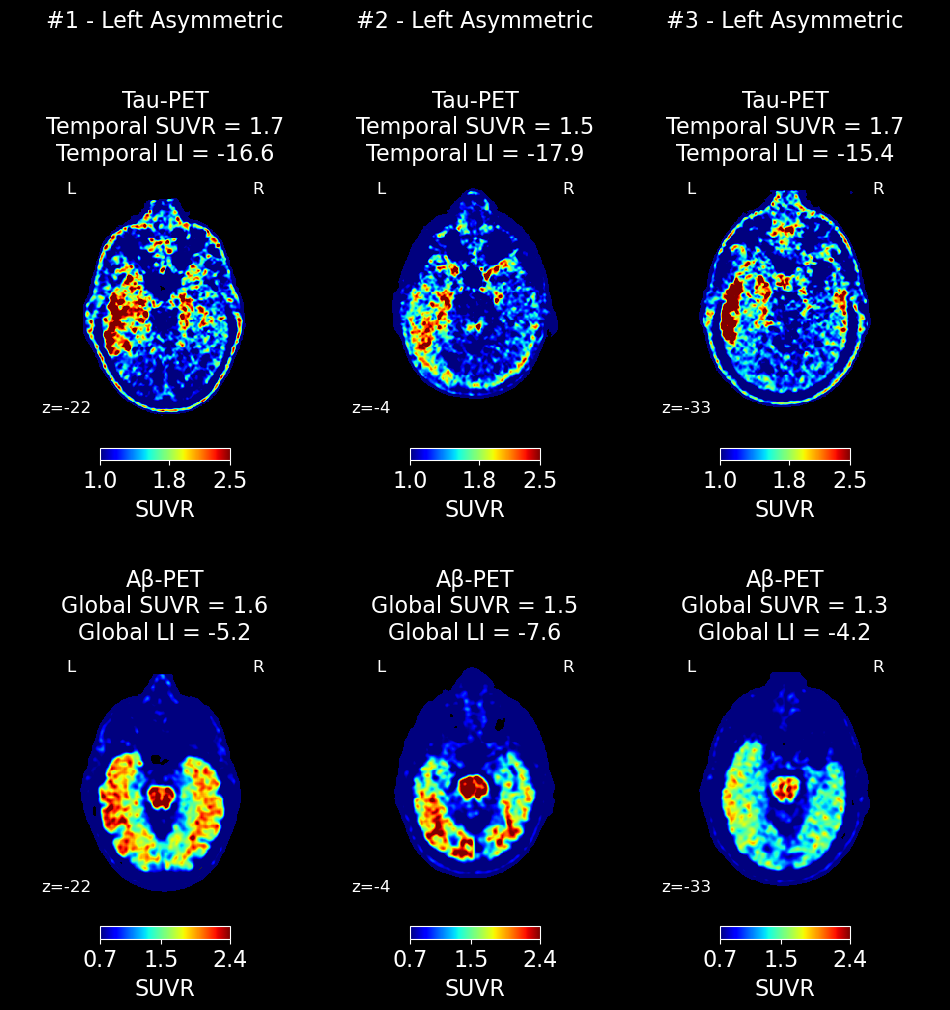

S {0: 'BOF112_BioFINDER2_260', 1: 'BOF112_BioFINDER2_298', 2: 'BOF112_BioFINDER2_1469'}
i=0, c=4, sub=BOF112_BioFINDER2_260, grp=S
BOF112_BioFINDER2_260__20180122
BOF112_BioFINDER2_260__20180123
i=1, c=5, sub=BOF112_BioFINDER2_298, grp=S
BOF112_BioFINDER2_298__20180226
BOF112_BioFINDER2_298__20180306
i=2, c=6, sub=BOF112_BioFINDER2_1469, grp=S
BOF112_BioFINDER2_1469__20210408
BOF112_BioFINDER2_1469__20210420


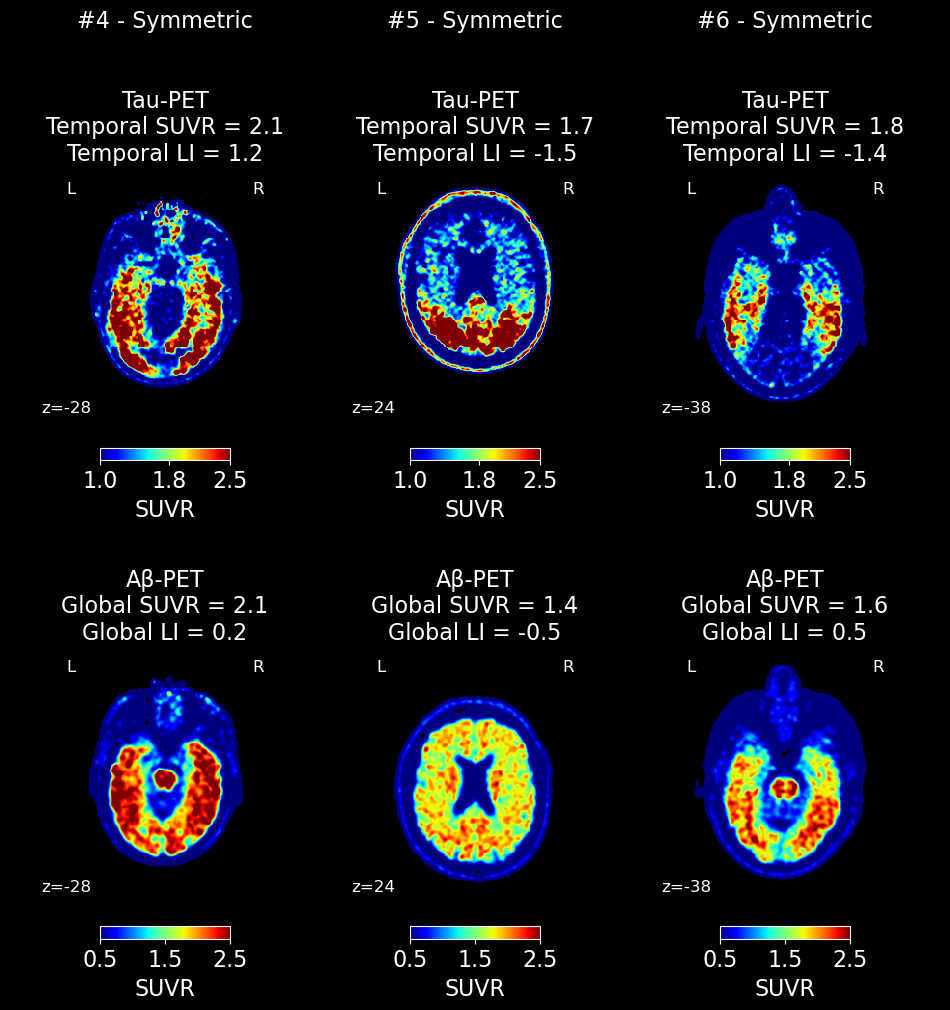

RA {0: 'BOF112_BioFINDER2_2273', 1: 'BOF112_BioFINDER2_2113', 2: 'BOF112_BioFINDER2_2366'}
i=0, c=7, sub=BOF112_BioFINDER2_2273, grp=RA
BOF112_BioFINDER2_2273__20230829
BOF112_BioFINDER2_2273__20230823
i=1, c=8, sub=BOF112_BioFINDER2_2113, grp=RA
BOF112_BioFINDER2_2113__20221213
BOF112_BioFINDER2_2113__20221215
i=2, c=9, sub=BOF112_BioFINDER2_2366, grp=RA
BOF112_BioFINDER2_2366__20231018
BOF112_BioFINDER2_2366__20231130


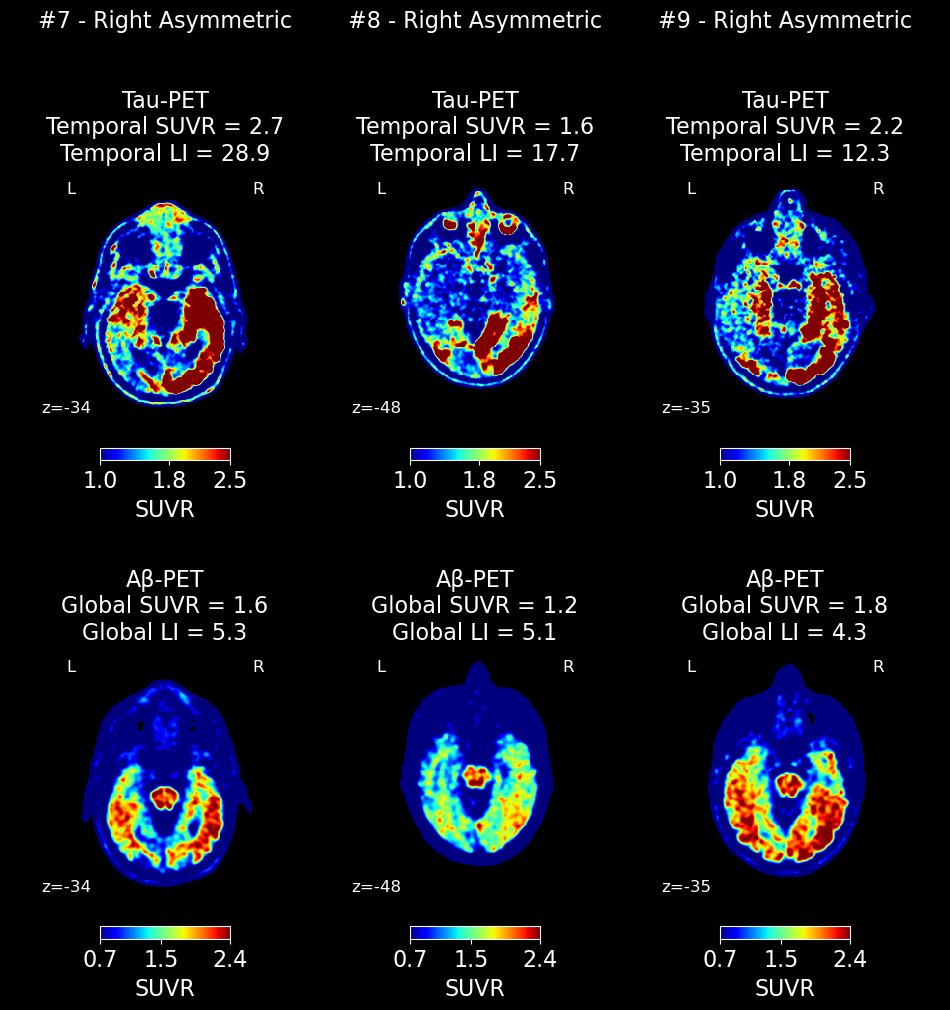

In [3]:
tau_lim = {'LA': [1.0, 2.5], 'S': [1.0, 2.5], 'RA': [1.0, 2.5]}
ab_lim = {'LA': [0.7, 2.4], 'S': [0.5, 2.5], 'RA': [0.7, 2.4]}
cmap = 'jet'

plt.rcParams.update({'font.size': 16, 'axes.titlesize': 16})

subs_dict = {
    'LA': {0: 'BOF112_BioFINDER2_1364', 1: 'BOF112_BioFINDER2_2252', 2: 'BOF112_BioFINDER2_1069'},
    'S': {0: 'BOF112_BioFINDER2_260', 1: 'BOF112_BioFINDER2_298', 2: 'BOF112_BioFINDER2_1469'},
    'RA': {0: 'BOF112_BioFINDER2_2273', 1: 'BOF112_BioFINDER2_2113', 2: 'BOF112_BioFINDER2_2366'}
}
path_cols = ['fnc_global', 'fnc_global_LI', 'tnic_temporal_meta', 'tnic_temporal_meta_LI']

### plotting

plt.style.use('dark_background')
grp_labels = {'LA': 'Left Asymmetric', 'S': 'Symmetric', 'RA': 'Right Asymmetric'}

c = 1
for grp, subs in subs_dict.items():
    fig, axs = plt.subplots(5, len(subs), figsize=(12, 10), 
        gridspec_kw={'height_ratios': [10, 0.5, 5, 10, 0.5], 'hspace': 0.25, 'wspace': 0})
    for l in range(len(subs)):
        axs[2, l].axis('off')
    print(grp, subs)
    for i, sub in subs.items():
        print(f'i={i}, c={c}, sub={sub}, grp={grp}')
        # read subject laterality
        df_li_s = df.loc[df['mid']==sub, ['mid', 'flutemetamol_pet_date__index', 'tau_pet_date__index']+path_cols]
        print(df_li_s['tau_pet_date__index'].iloc[0])
        print(df_li_s['flutemetamol_pet_date__index'].iloc[0])

        # read tau-PET data
        tau_anat_img = nib.load(os.path.join(cases_dir, 'tau_brain', df_li_s['tau_pet_date__index'].iloc[0], 'brain_reo_resample.nii.gz'))
        tau_suvr_img = nib.load(os.path.join(cases_dir, 'tnic_sr_mr', df_li_s['tau_pet_date__index'].iloc[0], 'suvrat_vox_mean_time_average_1.nii.gz'))

        # read ab-PET data
        ab_anat_img = nib.load(os.path.join(cases_dir, 'amyloid_brain', df_li_s['flutemetamol_pet_date__index'].iloc[0], 'brain_reo_resample.nii.gz'))
        try:
            ab_suvr_img = nib.load(os.path.join(cases_dir, 'fnc_sr_mr', df_li_s['flutemetamol_pet_date__index'].iloc[0], 'suvrat_vox_mean_time_average_4.nii.gz'))
        except:
            ab_suvr_img = nib.load(os.path.join(cases_dir, 'fnc_sr_mr', df_li_s['flutemetamol_pet_date__index'].iloc[0], 'suvrat_vox_mean_time_average_1.nii.gz'))

        # find axial slice with most tau uptake within the brain
        z = find_best_cut_coord(tau_suvr_img, tau_anat_img)
        
        # plot tau-PET
        title_tau = f"#{c} - {grp_labels[grp]}\n\n\nTau-PET\n"\
                    f"Temporal SUVR = {float(df_li_s['tnic_temporal_meta'].round(1))}\nTemporal LI = {float(df_li_s['tnic_temporal_meta_LI'].round(1))}"
        display = plotting.plot_anat(tau_anat_img, display_mode='z', cut_coords=[z], axes=axs[0, i], draw_cross=False)
        display.add_overlay(tau_suvr_img, cmap=cmap, alpha=1, vmin=tau_lim[grp][0], vmax=tau_lim[grp][1], threshold=0.1, colorbar=False)
        axs[0, i].set_title(title_tau)
        
        tau_sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=tau_lim[grp][0], vmax=tau_lim[grp][1]))
        tau_ticks = np.round(np.linspace(tau_lim[grp][0], tau_lim[grp][1], 3), 1)
        fig.colorbar(tau_sm, cax=axs[1, i], orientation='horizontal', label='SUVR', ticks=tau_ticks)

        pos = axs[0, i].get_position()
        axs[0, i].set_position([pos.x0 + 0.075, pos.y0, pos.width - 0.15, pos.height])
        pos = axs[1, i].get_position()
        axs[1, i].set_position([pos.x0 + 0.075, pos.y0, pos.width - 0.15, pos.height])

        # plot ab-PET
        title_ab = f"Aβ-PET\n"\
                   f"Global SUVR = {float(df_li_s['fnc_global'].round(1))}\nGlobal LI = {float(df_li_s['fnc_global_LI'].round(1))}"
        display = plotting.plot_anat(ab_anat_img, display_mode='z', cut_coords=[z], axes=axs[3, i], draw_cross=False)
        display.add_overlay(ab_suvr_img, cmap=cmap, alpha=1, vmin=ab_lim[grp][0], vmax=ab_lim[grp][1], threshold=0.1, colorbar=False)
        axs[3, i].set_title(title_ab)
        
        ab_sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=ab_lim[grp][0], vmax=ab_lim[grp][1]))
        ab_ticks = np.round(np.linspace(ab_lim[grp][0], ab_lim[grp][1], 3), 1)
        fig.colorbar(ab_sm, cax=axs[4, i], orientation='horizontal', label='SUVR', ticks=ab_ticks)
        
        pos = axs[3, i].get_position()
        axs[3, i].set_position([pos.x0 + 0.075, pos.y0, pos.width - 0.15, pos.height])
        pos = axs[4, i].get_position()
        axs[4, i].set_position([pos.x0 + 0.075, pos.y0, pos.width - 0.15, pos.height])

        c += 1

    plt.savefig(os.path.join(plot_dir, f'asymmetry_cases_{grp}.pdf'), format='pdf', dpi=300)
    plt.show()